<img src="images/ie_logo_png.png" style= "width:15%"/>

<img src="images/ambulance_imag.png" style= "width:6%"/>

Deep Learning & Reinforcement Learning
# **Group Assignment**
### **Highway Environment: Emergency Response Driving Challenge**
Professor: David Kremer

Assignment done by: 
- Adrian Marino
- Felipe Fischel
- Gilles Calderón
- Jean-Jacon Klat
- João André Pinho
- Nicholas Dieke
- Niccolo Borgato
- Max Heilingbrunner

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#  **Resolution**

##  **Part 0: Imports & Setup**

### **• Libraries and Module Imports:**

Importing the necessary libraries and modules to manipulate and interact with the dataset.

In [88]:
# Imports:
import gymnasium as gym
import highway_env
from highway_env.envs.highway_env import HighwayEnv
from stable_baselines3.common.callbacks import EvalCallback
from typing import Dict, Text
from highway_env import utils
from highway_env.envs.common.abstract import AbstractEnv
from highway_env.envs.common.action import Action
from highway_env.road.road import Road, RoadNetwork
from highway_env.utils import near_split
from highway_env.vehicle.controller import ControlledVehicle
from highway_env.vehicle.kinematics import Vehicle
from stable_baselines3.common.monitor import Monitor
import tensorflow as tf
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy

from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import os
import numpy as np
from datetime import datetime
import time
import torch
import multiprocessing

import imageio
from IPython import display
import matplotlib.pyplot as plt
import pprint
import matplotlib.animation as animation
from pyvirtualdisplay import Display

In [ ]:
# Useful pip installs.

#!pip install rl-agents

#!pip show rl_agents

#!pip install highway-env

#!pip install pyvirtualdisplay highway-env stable_baselines3

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part I: Setting Up and Understanding the Environment and Action Space**

Understand the environment - "Highway-v0" and action space that will be used and create an instance.

### **• Setup the Environment:**

Defining the environment and instanciating it.

In [90]:
# Defining the type of environment.
environment_name = 'highway-v0'

# Creating an instance of it and setting the render mode as "human" so the environment can be seen on video.
env = gym.make(environment_name, render_mode="human")

c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\utils\passive_env_checker.py:42: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


### **• Overview of the Environment Configuration:**

Holistic view of the current environment configuration settings.

In [91]:
# Checking the current environment configuration.
pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


### **• Understand the Current Action Space:**

Describing the current shape and type of the environment's action space.

In [92]:
# Checking the Default Action Space.
env.action_space

Discrete(5)

**Insight:** : As of now, the default action space is discrete and uses 5 different actions:
 
 - **0: Lane Left**
 - **1: Idle**
 - **2: Lane Right**
 - **3: Faster**
 - **4: Slower**

 This means the action space consists of 5 discrete actions, each of which can be represented as an integer from 0 to 4.

### **• Understand the Current Observation Space:**

Describing the current shape and type of the environment's observation space.

In [93]:
# Checking the Default Observation Space.
env.observation_space

Box(-inf, inf, (5, 5), float32)

**Insight:** The default Observation Space consists of a 2D 5x5 matrix, where each row corresponds to one vehicle in this environment and the columns correspond to different characteristics of that vehicle. For these observations, each element is a real number (a float), and there is no specific limit on the values that these numbers can take. 

### **• Change the Observation Space:**

Changing the observation space from array-based to image-based based on the provided documentation.

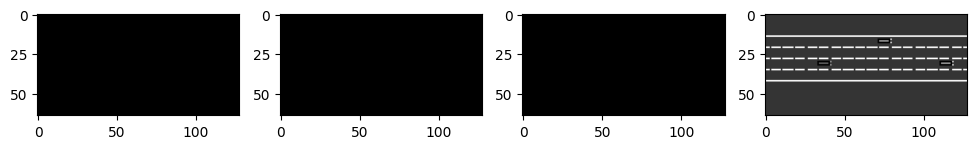

In [94]:
# Changing the Observation Space to a Grayscale Image based one.
%matplotlib inline
config = {
   "observation": {
       "type": "GrayscaleObservation",
       "observation_shape": (128, 64),
       "stack_size": 4,
       "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
       "scaling": 1.75,
   },
   "policy_frequency": 2
}

env.configure(config)
obs, info = env.reset()

fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
   ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

Illustration of the staking:

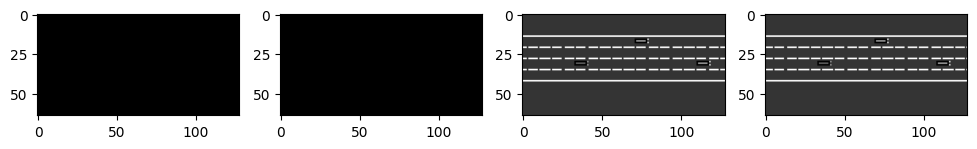

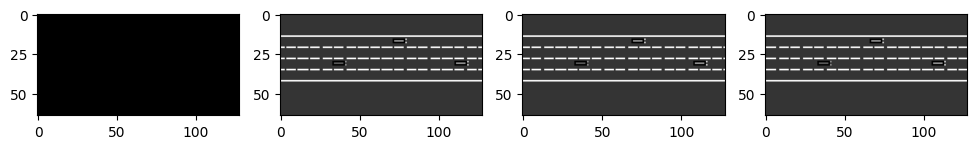

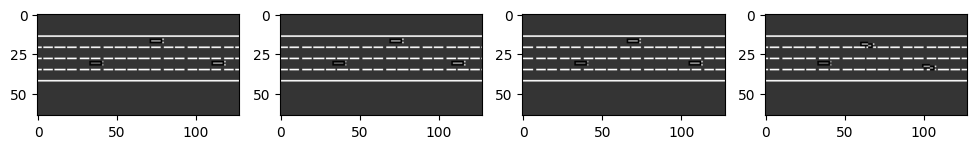

In [95]:
# Illustrating the stacking.
for _ in range(3):
    obs, reward, done, truncated, info = env.step(env.action_type.actions_indexes["IDLE"])

    fig, axes = plt.subplots(ncols=4, figsize=(12, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(obs[i, ...].T, cmap=plt.get_cmap('gray'))
plt.show()

In [96]:
# Checking the new Observation Space.
env.observation_space

Box(0, 255, (4, 128, 64), uint8)

**Insight:** The new Observation Space will consist of a 128x64 Grayscale four image stack from the Gameplay, where each image can take on a value from 0 (indicating black) to 255 (indicating white).

This change was performed in order to train a model that would represent more similarity with a real-world scenario. As autonomous driving vehicles primarily rely on visual input from cameras, training an RL agent with similar image-based inputs can make the learned policies more directly tranferable to this setting. Additionally, as images encapsulate a wider array of spacial details, such as positioning of surrounding vehicles, lane markings, and other environmental features, the model may gain a more comprehensive and valuable understanding of the scene, facilitating its learning and precise decion making process.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part II: Sampling from the Environment**

Perform "manual" sampling and let the agent take random actions in the environment in order to give a baseline of what to expect from an untrained agent.

### **• Render the Environment:**

Rendering the environment in a py-game window.

In [97]:
# Rendering the game environment.
env.render()

### **• Input Manual Actions:**

Selecting some manual actions to feed the agent in order to describe them, understand their meaning and check the states and final state that are generated.

In [100]:
# Manually input actions and understand what each action means:
def execute_predefined_actions(env):
    
    # Defining a sequence of actions.
    # (6x Lane Left, Lane Left, Lane Right, Idle, Faster, Faster, Slower, Lane Right)
    # Although previousy defined, this sequence might not get fully completed since with the ramdom setting of the environment some of these movements can result in a crash (ending the game earlier).
    actions = [0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4]

    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False

    # Initializing the score for the episode to 0.
    score = 0 

    # Reseting the environment to get the initial state - car starts at rest in the center of the road.
    state = env.reset()

    # Iterating over the provided list of actions.
    for action in actions:
        
        # Continues until the episode is done.
        if done:
            break
        
        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        n_state, reward, done, _, info = env.step(action)

        # Addding the reward to the total score.
        score += reward

        env.render()

    # The episode ended. `state` now contains the final state.
    if done:
        print("Episode ended. The Info dictionary at the terminal state was:", info)
        print("Final Score:", score)
        print("After move", action, "the State was:", n_state)

    # Closing the environment.
    env.close()

# Running the manual sequence of actions.
execute_predefined_actions(env)

Episode ended. The Info dictionary at the terminal state was: {'speed': 25.746634347414496, 'crashed': True, 'action': 3, 'rewards': {'collision_reward': 1.0, 'right_lane_reward': 1.0, 'high_speed_reward': 0.5741372092661606, 'on_road_reward': 1.0}}
Final Score: 20.506441055881957
After move 4 the State was: [[[99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  ...
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]]

 [[99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  ...
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]]

 [[99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  ...
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]]

 [[99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  ...
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]
  [99 99 99 ... 99 99 99]]]


**Insights:** As expected, the final state configuration instead of being represented by a 2D 5x5 array where each row represents a vehicle (the first one being the ego vehicle - the agent - and the others are the vehicles in the environment):

- 1st: **Existance of Active Status in the Environment** - represented by 1.0 in all vehicles;

- 2nd: **Longitudinal Position of the Vehicles Along the Road** - Ego vehicle is always at position 1.0, and the other vehicles have a relative position to it;

- 3rd: **Lateral Position of the Vehicles** - how far they are to the left or right of the center of the road (positive value indicates a position to the left, a negative value indicates a position to the right);

- 4th: **Relative Speed of Vehicles with respect to the Agent** - the speed difference between the agent and the other vehicles;

- 5th: **Acceleration of the Vehicles** - the acceleration of the vehicles, which is the change in speed from one time step to the next.

It is now represented by a 3-Dimensional stack of 4 grayscale images of the game environment, which shows a constant value of 99 for the pixels because these are the terminal frames when the game stopped due to the crash.

Regarding the Info Dictionary, this one provides more contextual details:

- **Speed:** The speed of the ego vehicle at the terminal state was approximately 23.76 units (the units for speed are not specified but could be km/h or m/s depending on the environment's configuration).
- **Crashed:** The episode ended in a crash, indicating that the ego vehicle crashed into another vehicle or an obstacle (represented by True).
- **Action:** The last action taken by the agent was 3, suggesting that the agent was attempting to move to the right.
- **Rewards:**  The "collision_reward" of 1.0 indicates that the agent received a penalty for crashing. The "right_lane_reward" of 0.67 suggests that the agent was almost in the rightmost lane at the time of the crash. The "high_speed_reward" of 0.38 shows that the agent was partially maintaining a high speed when it crashed. The "on_road_reward" of 1.0 indicates that the agent was on the road until the crash.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Setting 1 - Reward Function 1, PPO, Hyperparameter Set 1**

##  **Part III.1: Define the Reward Function**

Checking and adapting the current environment's reward function.

### **• Inspect the Current Reward Function:**

Holistic view of the current environment configuration settings and reward elements.

In [101]:
# Checking the current environment configuration.
pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'observation_shape': (128, 64),
                 'scaling': 1.75,
                 'stack_size': 4,
                 'type': 'GrayscaleObservation',
                 'weights': [0.2989, 0.587, 0.114]},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 2,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


**Insights:** The rewards structure was built to achieve two major goals:

- **Foster Safe Driving:** By penalizing collisions and rewading good driving behaviors;
- **Foster Efficient Driving:** By rewarding high speed.

This structure is composed by **6 different reward elements**:

1. **Collision Reward:** The agent receives a reward of -1 for colliding with another vehicle. This large negative reward encourages the agent to learn to avoid collisions. 

2. **Right Lane Reward:** The agent gets a reward of 0.1 for driving in the right-most lanes and this reward is linearly mapped to zero for other lanes. This simulates the common traffic rule in many countries where slower traffic should keep right, and the fastest lane (for overtaking) is the left-most one. The agent is thus encouraged to maintain right unless it needs to overtake.

3. **High Speed Reward:** The agent receives a reward of 0.4 for driving at the highest speed (full speed), which is linearly mapped to zero for lower speeds according to the range specified in the "reward_speed_range" parameter. This encourages the agent to reach its destination as quickly as possible, which is often a desired behavior in many driving scenarios. However, speed must be balanced with safety; hence the reward for avoiding collisions is higher (in absolute terms) than the reward for high speed.

4. **Lane Change Reward:** The agent gets a reward of 0 for each lane change action. This could be interpreted in different ways. One possible interpretation is that lane changes, in and of themselves, are neither good nor bad, but are merely tools that can be used to achieve other objectives (like avoiding collisions or driving fast).

5. **Normalization:**  The rewards are normalized, likely to keep the total reward within a certain range. and helping the stability of the learning algorithm.

6. **Offroad Terminal:** In this configuration, the offroad_terminal flag is set to False, meaning the agent isn't penalized for going off-road.

### **• Adapt Reward Function:**

Adapting the current reward function to optimize and better represent a real-world scenario.

Given the context of this project, which is modeling an autonomous driving ambulance that makes driving decisions based on Reinforcement Learning, some of the current reward criteria could be better adapted to resemble a real-world situation of attempting to get someone to the hospital as quickly as possible while maintaining the safety of the drivers and patients.

As so, the following changes will be performed: 

- **Slightly Penalize Lane Changes:** Deducting **-0.05** for each lane change in order to avoid frequent unecessary lane changes that might be dangerous and disruptive to other drivers.

- **Slightly Increase the High Speed Reward:** Boosting the high speed reward to **0.6**, to stimulate the urgency that Emergency Response teams should have to minimize the time of taking a patient to the hospital in a between life and death in an emergency context.

- **Set the Off Road Terminal Flag to True:** Forbiding the ambulance to go off road, as this scenario is considered to be a serious dangerous driving crime in a real highway driving scenario.

- **Reward Safe Distance from Other Cars:** Rewarding increases of the minimum distance to other cars, in order to make the ride safer (and to reduce the risk of collisions).

In [24]:
# Defining a new environment class that inherits from the original HighwayEnv.
class MyHighwayEnv(HighwayEnv):
    # Defining the class method to provide the configurations of the environment.
    @classmethod
    def default_config(cls) -> dict:
        # Getting the default configurations from the parent class.
        config = super().default_config()
        # Updating the default configuration with the new parameters.
        config.update({
            
            # Defining the configuration for the observation space - image-based.
            "observation": {
                "type": "GrayscaleObservation",
                "observation_shape": (128, 64),
                "stack_size": 4,
                "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
                "scaling": 1.75,
            },

            # Defining the configuration for the action space - discrete.
            "action": {
                "type": "DiscreteMetaAction",
            },

            # Defining the configuration for the reward and policy functions.
            "lanes_count": 4,
            "vehicles_count": 50,
            "controlled_vehicles": 1,
            "initial_lane_id": None,
            "duration": 40,  # [s]
            "ego_spacing": 2,
            "vehicles_density": 1,

            # Penalizing for collisions.
            "collision_reward": -1,

            # Rewarding good driving behavior of being on the right lane.
            "right_lane_reward": 0.1,

            # Increasing the high speed reward.
            "high_speed_reward": 0.6,
            
            # Penalizing the lane changes.
            "lane_change_reward": -0.05,

            # Rewarding a safe distance from other cars.
            "safe_distance_reward": 0.1,  

            "reward_speed_range": [20, 30],

            # Normalizing the rewards.
            "normalize_reward": True,

            # Prohibiting going off road.
            "offroad_terminal": True,
            "policy_frequency": 2
        })

        return config

    # Adapting the scalar method to compute the total reward.
    def _reward(self, action: Action) -> float:
        """
        The reward is defined to foster driving at high speed, on the rightmost lanes, and to avoid collisions.
        :param action: the last action performed
        :return: the corresponding reward
        """
        # Calling the _rewards function to get a dictionary of all individual reward components.
        rewards = self._rewards(action)

        # Fetching and summing up all the individual rewards to get the total reward.
        # If the reward is not defined, a default value of 0 is used.
        reward = sum(self.config.get(name, 0) * reward for name, reward in rewards.items())
        
        
        # Normalizing the reward.
        # The reward is mapped to this range based on its value relative to the sum of "collision_reward", "high_speed_reward", "right_lane_reward", and "safe_distance_reward" (if it exists).
        if self.config["normalize_reward"]:
            reward = utils.lmap(reward,
                                [self.config["collision_reward"],
                                self.config["high_speed_reward"] + self.config["right_lane_reward"] + self.config.get("safe_distance_reward", 0)],
                                [0, 1])
        
        # Scaling the reward by the 'on_road_reward', which is 1 if the vehicle is on the road and 0 otherwise.
        reward *= rewards['on_road_reward']
        return reward

    # Adapting the method to compute each reward element.
    def _rewards(self, action: Action) -> Dict[Text, float]:

        # Getting the indices of all lanes that are parallel and have the same direction as the current lane.
        neighbours = self.road.network.all_side_lanes(self.vehicle.lane_index)

        # Getting the index of the target lane if the vehicle is controlled, otherwise getting the index of the current lane.
        lane = self.vehicle.target_lane_index[2] if isinstance(self.vehicle, ControlledVehicle) \
            else self.vehicle.lane_index[2]


        # Calculating the forward speed of the vehicle, which is the component of the vehicle's speed in the direction of the road.
        forward_speed = self.vehicle.speed * np.cos(self.vehicle.heading)

        # Mapping the forward speed to a range of [0, 1] based on the "reward_speed_range" defined in the config.
        scaled_speed = utils.lmap(forward_speed, self.config["reward_speed_range"], [0, 1])
        
        # Calculating the minimum distance to other vehicles.
        min_distance = float("inf")
        for v in self.road.vehicles:
            if v is not self.vehicle:
                distance = np.linalg.norm(self.vehicle.position - v.position)
                min_distance = min(min_distance, distance)
        
        # Returning a dictionary with the individual rewards for each component.
        return {
            "collision_reward": float(self.vehicle.crashed), # Will be 1 if the vehicle has crashed, 0 otherwise.
            "right_lane_reward": lane / max(len(neighbours) - 1, 1), # The fraction of the number of lanes to the right of the current lane.
            "high_speed_reward": np.clip(scaled_speed, 0, 1), # The forward speed of the vehicle scaled to the range [0, 1]
            "on_road_reward": float(self.vehicle.on_road), # Will be 1 if the vehicle is on the road (self.vehicle.on_road is True) and 0 otherwise.
            "safe_distance_reward": utils.lmap(min_distance, [0, 100], [0, 1])  # Scale the minimum distance to other vehicles (min_distance) to the range [0, 1] over a range of 0 to 100 meters. 
        }
    
    # Configuring the render mode.
    def configure(self, render_mode="human"):
        self.config["render_mode"] = render_mode


### **• Test the Reward Function with a Random Policy:**

Letting the agent take random actions in the environment with the new reward function, in order to give a baseline of what to expect from an untrained agent.

In [25]:
# Declaring the environment with the reward function changes.
env = MyHighwayEnv(render_mode = "human")

In [26]:
# Defining the number of episodes - number of times the game will restart itself when:
#   A. The car crashes.
#   B. The car goes outside of the track.

episodes = 10

# Initializing an empty list to all generated data.
data = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):

    # Initializing an empty list for the current episode data.
    episode_data = []
    
    # Reseting the environment to get the initial state - car starts at rest in the center of the road.
    state = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False
    
    # Initializing the score for the episode to 0.
    score = 0 
    
    # Starting a loop that continues until the episode is done.
    while not done:
        
        # Choosing an action randomly from the action space of the environment.
        action = env.action_space.sample()
        
        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        n_state, reward, done, _, info = env.step(action)

        # Storing the [observation, action, reward, next observation, final state] data.
        data.append([state, action, reward, n_state, done])
        
        # Adding the reward for this step to the score.
        score += reward

        # Setting the current state to the new state.
        state = n_state

    # Printing out the score for the episode after its conclusion.
    pprint.pprint(f'Episode:{episode} Score:{score}')
    
# Closing the environment.
env.close()

# Calculating the average reward over the 10 episodes.
total_reward = sum(data_point[2] for data_point in data)
average_reward = total_reward / episodes

# Printing the average reward.
print("Average Reward:", average_reward)

'Episode:1 Score:20.03176854357967'
'Episode:2 Score:4.396648019345016'
'Episode:3 Score:63.96622908778545'
'Episode:4 Score:29.829702179351496'
'Episode:5 Score:7.060643814336156'
'Episode:6 Score:8.889712304068297'
'Episode:7 Score:20.77650157176086'
'Episode:8 Score:6.121075766847082'
'Episode:9 Score:33.280546051376184'
'Episode:10 Score:3.081906896990797'
Average Reward: 19.743473423544096


**Insight:** As seen, without properly training the agent to appropriatly define the right actions to take, the accumulated final scores will be very poor (average = 19.74). 

Despite the possible improvements that were made to the reward function (given the explored problem setting), in order to improve these scores the agent must be trained to:

1. **Gather samples from the gameplay (i.e., running the policy);**
2. **Fit a model that estimates the total final return;**
3. **Improving the policy, in order to generate at each step an action with the end goal of maximizing the final acuumulated reward.**

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part IV.1: Prepare the Agent**

Creating a wrapper and an agent to test a random policy for the discrete environment.

### **• Set up TensorBoard Log Directory:**

Setting up TensorBoard in order to later collect important model statistics.

In [36]:
models_dir = f'Training/Saved Models/PPO/Highway-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
log_dir = f'Training/logs/PPO/Highway-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

### **• Create an Environment Instance and Wrap it:**

Creating a new environment instance and wrapping it with the DummyVecEnc class from Stable Baselines3. This will turn the environment into a vectorized environment that allows for multiples copies to be run in parallel.

In [29]:
# Declaring the environment with the reward function changes.
env = MyHighwayEnv(render_mode = "human")

# Creating a Monitor wrapper to log the training data.
env = Monitor(env, log_dir)

# Wraping the environment to make it compatible with Stable Baselines3 library - which expects a vectorized environment.
env = DummyVecEnv([lambda: env])

**Insight:** In this case, since the current action space was already discrete (5 actions) and the observation configuration was already a set of 4 sequential grayscale images , the only needed wrapper will be the one to make it compatible with the Stable Baselines3 library for importing the agent. Wrapping it again and running the same tests would be redundant since this was already done before and nothing else (like the agent or policy) changed since then.

In this way, the agent will be later configured once the Policy is defined.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part V.1: Prepare the Policy Optizimation Method - Proximal Policy Optimization (PPO)**

Preparing the PPO algorithm and the CNN for the training stage.

### **• Setup the Agent and Policy**

Creating an agent using the **Proximal Policy Optimization** algorithm.

This algorithm was built in order to optimize the decisions made by an agent in a given environment in order to maximize the notion of cumulative reward. The idea behind consists of taking steps in the direction that improves the policy, but not too large ones that might harm the performance. In other words, it seeks an optimal policy that is close to the current policy. 

Mathematically, PPO aims to find the optimal policy π(θ) that maximizes the objective:
<center><img src="images/ppo_formula.png"/></center>

The main innovation of the this algorithm is the introduction of a "Clipping" mechanism that penalizes changes in the policy that deviate too much from the curren policy.

In terms of the Policy, "CNNPolicy" - a policy architecture option that is especially good at processing grid-like data (i.e., images) was chosen. This CNN, particularly good for game environments, will take in the image-based observation from the environment, process it through its layers to detect important features, and then output an action (or a distribution over actions) that the agent should take.

In [19]:
# Defining the Agent and the Policy.
model = PPO("CnnPolicy", 
            # Defining the environment the model will use.
            env, 
            # Defining the level of detail of training logs.
            verbose=1,
            # Defining the discount factor for future rewards (how much the agent cares about rewards in the distance future relative to immediate ones).
            gamma=0.99,  
            # Defining the trade-off between exploration (trying out new actions) and exploitation (sticking to what's known to work)
            ent_coef=0.01, 
            # Defining the learning rate for the optimizer.
            learning_rate=0.00025, 
            # Defining the value function coefficient - scaling factor to change the contribution of the value function loss to the total loss function.
            vf_coef=0.5, 
            # Defining the maximum value for the gradient clipping.
            max_grad_norm=0.5,
            # Defining the trade-off between variance and bias - technique to reduce variance.
            gae_lambda=0.95,
            # Defining the clipping parameter for the policy update - how much the new policy can deviate from the old policy during each update.
            clip_range=0.2,
            # Updating the tensorboard log directory. 
            tensorboard_log=log_dir)

Using cpu device


In [31]:
# Defining the Agent and the Policy.
model = PPO("CnnPolicy", 
            # Defining the environment the model will use.
            env, 
            # Defining the level of detail of training logs.
            verbose=1)

Using cpu device


In [32]:
# Inspect the Model policy CNN Architecture.
model.policy

ActorCriticCnnPolicy(
  (features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3072, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (pi_features_extractor): NatureCNN(
    (cnn): Sequential(
      (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Flatten(start_dim=1, end_dim=-1)
    )
    (linear): Sequential(
      (0): Linear(in_features=3072, out_features=512, bias=True)
      (1): ReLU()
    )
  )
  (vf_features_extractor): NatureCNN(
    (cnn): 

### **• Test the New Policy and Agent:**

Testing the New Policy with the previously configured agent, without any training.

In [33]:
# Running multiple episodes and record the scores and time steps.
episodes = 10
scores_array = []
timestep_arr = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):
    # Resetting the environment to get the initial state - car starts at rest in the center of the road.
    obs = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False

    # Initializing the score for the episode to 0.
    score = 0

    # Initializing the timestep as 0.
    timestep = 0
    
    # Starting a loop that continues until the episode is done.
    while not done:

        # Choosing an action randomly from the action space of the environment.
        action, _ = model.predict(obs)

        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        obs, reward, done, info = env.step(action)
        
        # Adding the reward for this step to the score.
        score += reward

        # Incrementing the timesteps.
        timestep += 1
        
        # Render the environment.
        env.render()
    
    # Saving both the scores and timesteps.
    scores_array.append(score)
    timestep_arr.append(timestep)

    # Printing out the score for the episode after its conclusion.
    print("Episode:{} Score:{}".format(episode, score))

# CLosing the environment.
env.close()

# Calculating the average reward over the 10 episodes.
total_reward = sum(scores_array)
average_reward = total_reward / episodes

# Printing the average reward.
print("Average Reward:", average_reward)

Episode:1 Score:[2.9394882]
Episode:2 Score:[49.511543]
Episode:3 Score:[4.51984]
Episode:4 Score:[8.436631]
Episode:5 Score:[10.931718]
Episode:6 Score:[18.60847]
Episode:7 Score:[4.2792044]
Episode:8 Score:[26.44286]
Episode:9 Score:[15.164019]
Episode:10 Score:[46.941734]
Average Reward: [18.777552]


**Insight:** Although the improvements on the actions that the car takes are noticeable, it is clear that the agent is definetly not trained as given for a specific environment setting the car actions aren't yet perfect. Given such poor generated scores, the hypothesis that can be raised is that with a larger amount of training steps, the agent will be able to learn a better policy in order to take actions that will maximize the accumulated score.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part VI.1: Training Stage - Proximal Policy Optimization (PPO)**

Now that the environment, agent and policy are properly configured and after confirming the poor results from not training the agent, the PPO/CNN Policy model combination will be trained for 2 longer periods of time to see if this will improve its performance.

In [34]:
# Defining a callback to write summaries in tensorboard during training.
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """
    def __init__(self, check_freq: int, log_dir: str, models_dir: str, verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.models_dir = models_dir
        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean reward of the last 100 episodes
                mean_reward = np.mean(y[-100:])
                self.logger.record('rollout/mean_reward', float(mean_reward))
                
                # Save model
                save_path = os.path.join(self.models_dir, f'model_step_{self.num_timesteps}')
                self.model.save(save_path)

        return True

# Creating the TensorBoardCallback instance.
callback = TensorboardCallback(check_freq=5000, log_dir=log_dir, models_dir=models_dir)

In [ ]:
# Training the short model timesteps - 20K.
#model.learn(total_timesteps=20000, callback=callback)

In [38]:
# Deleting the model.
del model

------------------------------

##  **Part VII.1: Evaluation and Testing Stages**

Evaluating the performance of the testing performed with the long timestepped model.

### **• Create an Environment Instance and Wrap it:**

Creating a new environment instance and wrapping it with the DummyVecEnc class from Stable Baselines3. This will turn the environment into a vectorized environment that allows for multiples copies to be run in parallel.

In [24]:
# Declaring the environment with the reward function changes.
env = MyHighwayEnv(render_mode = "human")

# Wraping the nevironment to make it compatible with Stable Baselines3 library - which expects a vectorized environment.
env = DummyVecEnv([lambda: env])

### **• Load the Model:**

Loading the longer trained model from its orginal path.

The best model, based on the data gathered during the training stage, will be loaded around step 20000.

In [25]:
# Load the best saved model.
PPO_path = os.path.join('Training', 'Saved Models', 'PPO', 'Highway-2023-07-02_17-58-25', 'model_step_20000')

In [26]:
# Loading the model to see if it was properly saved.
model = PPO.load(PPO_path, env=env)

c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object clip_range. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(


### **• Model Evaluation:**

This step is done to measure the performance of the trained agent. Evaluation gives us an estimate of how well the agent will perform and can be used to compare different models or configurations. 

In [27]:
# Evaluating the performance of the best trained model.
evaluate = evaluate_policy(model, env, n_eval_episodes=2, render=True)
print(evaluate)

c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(48.15267017483711, 1.393639236688614)


### **• Model Testing:**

This step is done as a final assessment of the agent, in order to check how it would operate in the real world given the model that it was trained on.

In [28]:
# Running multiple episodes and record the scores and time steps.
episodes = 10
scores_array = []
timestep_arr = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):
    # Resetting the environment to get the initial state - car starts at rest in the center of the road.
    obs = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False

    # Initializing the score for the episode to 0.
    score = 0

    # Initializing the timestep as 0.
    timestep = 0
    
    # Starting a loop that continues until the episode is done.
    while not done:

        # Choosing an action randomly from the action space of the environment.
        action, _ = model.predict(obs)

        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        obs, reward, done, info = env.step(action)
        
        # Adding the reward for this step to the score.
        score += reward

        # Incrementing the timesteps.
        timestep += 1
        
        # Render the environment.
        env.render()
    
    # Saving both the scores and timesteps.
    scores_array.append(score)
    timestep_arr.append(timestep)

    # Printing out the score for the episode after its conclusion.
    print("Episode:{} Score:{}".format(episode, score))

# CLosing the environment.
env.close()

# Calculating the average reward over the 10 episodes.
total_reward = sum(scores_array)
average_reward = total_reward / episodes

# Printing the average reward.
print("Average Reward:", average_reward)

Episode:1 Score:[46.979393]
Episode:2 Score:[45.627705]
Episode:3 Score:[45.950012]
Episode:4 Score:[48.068104]
Episode:5 Score:[47.29076]
Episode:6 Score:[47.010593]
Episode:7 Score:[47.80622]
Episode:8 Score:[47.070576]
Episode:9 Score:[46.227947]
Episode:10 Score:[46.999123]
Average Reward: [46.90304]


------------------------------

##  **Part VIII.1: Score Analysis**

Plotting the scores and time steps for each episode to analyze the performance of the model.

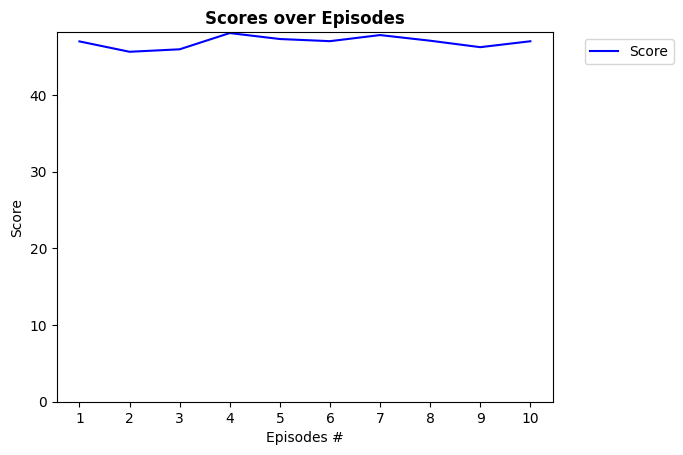

In [29]:
# Plotting the scores and timestep per episode.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_array)+1), scores_array, label="Score", color='blue')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.ylim(0,)
plt.xticks(np.arange(1, len(scores_array)+1))
plt.xlabel('Episodes #')
plt.title("Scores over Episodes", fontweight='bold' )
plt.show()

**Insight:** As observable, with the longest trained and best performing model the results far exceeded the ones from the first testing stages. Despite not breaking the 50 points goal that was set in the beginning of the experience, the scores have shown to be very regular which showcases the model robustness to different environments and the opportunity to improve it after some proper hyperparameter tuning or a different optimizer choice. Furthermore, the fact that the car rarely attempted to overcome someone may indicate the inneficiency of the safe distance and lane change rewards. As such, these ones will be adapted in the next setting test.

------------------------------

# **Setting 2 - Reward Function 2, PPO, Hyperparameter Set 2**

##  **Part III.2: Define the Reward Function**

Checking and adapting the current environment's reward function after the observations on Setting 1.

### **• Adapt Reward Function:**

Adapting the current reward function given the behaviors observed in setting 1 to optimize and better represent a real-world scenario.

Given the context of this project and the behaviors observed in Setting 1, some of the previous reward criteria could be better adapted to resemble a real-world situation of attempting to get someone to the hospital as quickly as possible while maintaining the safety of the drivers and patients.

As so, the following changes will be performed:

- **Reducing the Penalty for Lane Changes:** Reducing the previous configured penalty to **-0.04**, in order to incentivize the ambulance to overcome other cars instead of remaining static in its own lane.

- **Slightly Increase the High Speed Reward:** Boosting the high speed reward to **0.7**, to stimulate even more the urgency that Emergency Response teams should have to minimize the time of taking a patient to the hospital in a between life and death in an emergency context.

- **Remove the Safe Distance Reward:** Removing the safe distance reward in order to stimulate the ambulance to drive faster and overcome some of the other cars.

In [68]:
# Defining a new environment class that inherits from the original HighwayEnv.
class MyHighwayEnv(HighwayEnv):
    # Defining the class method to provide the configurations of the environment.
    @classmethod
    def default_config(cls) -> dict:
        # Getting the default configurations from the parent class.
        config = super().default_config()
        # Updating the default configuration with the new parameters.
        config.update({
            
            # Defining the configuration for the observation space - image-based.
            "observation": {
                "type": "GrayscaleObservation",
                "observation_shape": (128, 64),
                "stack_size": 4,
                "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
                "scaling": 1.75,
            },

            # Defining the configuration for the action space - discrete.
            "action": {
                "type": "DiscreteMetaAction",
            },

            # Defining the configuration for the reward and policy functions.
            "lanes_count": 4,
            "vehicles_count": 50,
            "controlled_vehicles": 1,
            "initial_lane_id": None,
            "duration": 40,  # [s]
            "ego_spacing": 2,
            "vehicles_density": 1,

            # Penalizing for collisions.
            "collision_reward": -1,

            # Rewarding good driving behavior of being on the right lane.
            "right_lane_reward": 0.1,

            # Increasing the high speed reward comparing to setting 1.
            "high_speed_reward": 0.7,
            
            # Reducing the penalty for lane changes.
            "lane_change_reward": -0.04,

            # Removing the safe distance reward.
            #"safe_distance_reward": 0.1,  

            "reward_speed_range": [20, 30],

            # Normalizing the rewards.
            "normalize_reward": True,

            # Prohibiting going off road.
            "offroad_terminal": True,
            "policy_frequency": 2
        })

        return config

    # Adapting the scalar method to compute the total reward.
    def _reward(self, action: Action) -> float:
        """
        The reward is defined to foster driving at high speed, on the rightmost lanes, and to avoid collisions.
        :param action: the last action performed
        :return: the corresponding reward
        """
        # Calling the _rewards function to get a dictionary of all individual reward components.
        rewards = self._rewards(action)

        # Fetching and summing up all the individual rewards to get the total reward.
        # If the reward is not defined, a default value of 0 is used.
        reward = sum(self.config.get(name, 0) * reward for name, reward in rewards.items())
        
        # Normalizing the reward.
        # The reward is mapped to this range based on its value relative to the sum of "collision_reward", "high_speed_reward", "right_lane_reward".
        if self.config["normalize_reward"]:
            reward = utils.lmap(reward,
                                [self.config["collision_reward"],
                                self.config["high_speed_reward"] + self.config["right_lane_reward"]],
                                [0, 1])
        
        # Scaling the reward by the 'on_road_reward', which is 1 if the vehicle is on the road and 0 otherwise.
        reward *= rewards['on_road_reward']
        return reward

    # Adapting the method to compute each reward element.
    def _rewards(self, action: Action) -> Dict[Text, float]:

        # Getting the indices of all lanes that are parallel and have the same direction as the current lane.
        neighbours = self.road.network.all_side_lanes(self.vehicle.lane_index)

        # Getting the index of the target lane if the vehicle is controlled, otherwise getting the index of the current lane.
        lane = self.vehicle.target_lane_index[2] if isinstance(self.vehicle, ControlledVehicle) \
            else self.vehicle.lane_index[2]


        # Calculating the forward speed of the vehicle, which is the component of the vehicle's speed in the direction of the road.
        forward_speed = self.vehicle.speed * np.cos(self.vehicle.heading)

        # Mapping the forward speed to a range of [0, 1] based on the "reward_speed_range" defined in the config.
        scaled_speed = utils.lmap(forward_speed, self.config["reward_speed_range"], [0, 1])
        
        # Returning a dictionary with the individual rewards for each component.
        return {
            "collision_reward": float(self.vehicle.crashed), # Will be 1 if the vehicle has crashed, 0 otherwise.
            "right_lane_reward": lane / max(len(neighbours) - 1, 1), # The fraction of the number of lanes to the right of the current lane.
            "high_speed_reward": np.clip(scaled_speed, 0, 1), # The forward speed of the vehicle scaled to the range [0, 1]
            "on_road_reward": float(self.vehicle.on_road), # Will be 1 if the vehicle is on the road (self.vehicle.on_road is True) and 0 otherwise. 
        }
    
    # Configuring the render mode.
    def configure(self, render_mode="human"):
        self.config["render_mode"] = render_mode


### **• Test the Reward Function with a Random Policy:**

Letting the agent take random actions in the environment with the new reward function, in order to give a baseline of what to expect from an untrained agent.

In [69]:
# Declaring the environment with the reward function changes.
env = MyHighwayEnv(render_mode = "human")

In [70]:
# Defining the number of episodes - number of times the game will restart itself when:
#   A. The car crashes.
#   B. The car goes outside of the track.

episodes = 10

# Initializing an empty list to all generated data.
data = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):

    # Initializing an empty list for the current episode data.
    episode_data = []
    
    # Reseting the environment to get the initial state - car starts at rest in the center of the road.
    state = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False
    
    # Initializing the score for the episode to 0.
    score = 0 
    
    # Starting a loop that continues until the episode is done.
    while not done:
        
        # Choosing an action randomly from the action space of the environment.
        action = env.action_space.sample()
        
        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        n_state, reward, done, _, info = env.step(action)

        # Storing the [observation, action, reward, next observation, final state] data.
        data.append([state, action, reward, n_state, done])
        
        # Adding the reward for this step to the score.
        score += reward

        # Setting the current state to the new state.
        state = n_state

    # Printing out the score for the episode after its conclusion.
    pprint.pprint(f'Episode:{episode} Score:{score}')
    
# Closing the environment.
env.close()

# Calculating the average reward over the 10 episodes.
total_reward = sum(data_point[2] for data_point in data)
average_reward = total_reward / episodes

# Printing the average reward.
print("Average Reward:", average_reward)

'Episode:1 Score:22.39766686845734'
'Episode:2 Score:23.786542788524276'
'Episode:3 Score:22.060077537378564'
'Episode:4 Score:16.083087966932162'
'Episode:5 Score:15.91375381546268'
'Episode:6 Score:18.716107851581015'
'Episode:7 Score:20.55436889739848'
'Episode:8 Score:9.784913693411342'
'Episode:9 Score:18.449149471357035'
'Episode:10 Score:16.861686083205587'
Average Reward: 18.46073549737087


**Insight:** As seen, still without properly training the agent to appropriatly define the right actions to take, the accumulated final scores will be very poor (average = 20.48). 

Despite the possible improvements that were made to the reward function (given the explored problem setting and some of the corrections from setting 1), in order to improve these scores the agent must be trained to:

1. **Gather samples from the gameplay (i.e., running the policy);**
2. **Fit a model that estimates the total final return;**
3. **Improving the policy, in order to generate at each step an action with the end goal of maximizing the final acuumulated reward.**

##  **Part IV.2: Prepare the Agent**

Creating a wrapper and an agent to test a random policy for the discrete environment.

### **• Set up TensorBoard Log Directory:**

Setting up TensorBoard in order to later collect important model statistics.

In [72]:
models_dir2 = f'Training/Saved Models/DQN/Highway2-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
log_dir2 = f'Training/logs/DQN/Highway2-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'

if not os.path.exists(models_dir2):
    os.makedirs(models_dir2)
    
if not os.path.exists(log_dir2):
    os.makedirs(log_dir2)

### **• Create an Environment Instance and Wrap it:**

Creating a new environment instance and wrapping it with the DummyVecEnc class from Stable Baselines3. This will turn the environment into a vectorized environment that allows for multiples copies to be run in parallel.

In [73]:
# Declaring the environment with the reward function changes.
env = MyHighwayEnv(render_mode = "human")

# Creating a Monitor wrapper to log the training data.
env = Monitor(env, log_dir2)

# Wraping the environment to make it compatible with Stable Baselines3 library - which expects a vectorized environment.
env = DummyVecEnv([lambda: env])

**Insight:** In this case, since the current action space was already discrete (5 actions) and the observation configuration was already a set of 4 sequential grayscale images , the only needed wrapper will be the one to make it compatible with the Stable Baselines3 library for importing the agent. Wrapping it again and running the same tests would be redundant since this was already done before and nothing else (like the agent or policy) changed since then.

In this way, the agent will be later configured once the Policy is defined.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part V.1: Prepare the Policy Optimization Method - DQN**

Preparing the dqn algorithm and the CNN for the training stage.

### **• Setup the Agent and Policy**

Creating an agent using the **Deep Q-Network** algorithm.

This algorithm takes the classic Q-learning technique and combines with deep neural networks. DQN aims to find the best action to take in a given state in order to maximize the expected cumulative reward. It achieves this by learning an optimal policy π(θ) that yields the highest Q-value, representing the best expected future reward for a given action in a state.

<center><img src="images/q_dqn_formula.png"/></center>

The true innovation of DQN is the combination of Q-learning with a flexible function approximator through deep learning. This powerful combination allows DQN to handle high-dimensional observation spaces that are typically not feasible with classic Q-learning.

In terms of the Policy, the same "CNNPolicy" - a policy architecture option that is especially good at processing grid-like data (i.e., images) was chosen. This CNN, particularly good for game environments, will take in the image-based observation from the environment, process it through its layers to detect important features, and then output an action (or a distribution over actions) that the agent should take.

In [ ]:
# Deleting the previous model from memory.
del model

In [27]:
# Defining the Agent and the Policy.
model = DQN("CnnPolicy", 
            # Defining the environment the model will use.
            env, 
            # Defining the level of detail of training logs.
            verbose=1,
            # Defining the discount factor for future rewards (how much the agent cares about rewards in the distance future relative to immediate ones).
            gamma=0.70,
            # Lowering the buffer_size.
            buffer_size=10000,
            # Defining the learning rate for the optimizer.
            learning_rate=0.001,
            # Defining the initial exploration rate.
            exploration_initial_eps = 1.0,
            # Updating the tensorboard log directory. 
            tensorboard_log=log_dir2)

Using cpu device


In [28]:
# Inspect the Model policy CNN Architecture.
model.policy

CnnPolicy(
  (q_net): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_dim=-1)
      )
      (linear): Sequential(
        (0): Linear(in_features=3072, out_features=512, bias=True)
        (1): ReLU()
      )
    )
    (q_net): Sequential(
      (0): Linear(in_features=512, out_features=5, bias=True)
    )
  )
  (q_net_target): QNetwork(
    (features_extractor): NatureCNN(
      (cnn): Sequential(
        (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
        (3): ReLU()
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (5): ReLU()
        (6): Flatten(start_dim=1, end_di

### **• Test the New Policy and Agent:**

Testing the New Policy with the previously configured agent, without any training.

In [37]:
# Running multiple episodes and record the scores and time steps.
episodes = 10
scores_array = []
timestep_arr = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):
    # Resetting the environment to get the initial state - car starts at rest in the center of the road.
    obs = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False

    # Initializing the score for the episode to 0.
    score = 0

    # Initializing the timestep as 0.
    timestep = 0
    
    # Starting a loop that continues until the episode is done.
    while not done:

        # Choosing an action randomly from the action space of the environment.
        action, _ = model.predict(obs)

        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        obs, reward, done, info = env.step(action)
        
        # Adding the reward for this step to the score.
        score += reward

        # Incrementing the timesteps.
        timestep += 1
        
        # Render the environment.
        env.render()
    
    # Saving both the scores and timesteps.
    scores_array.append(score)
    timestep_arr.append(timestep)

    # Printing out the score for the episode after its conclusion.
    print("Episode:{} Score:{}".format(episode, score))

# CLosing the environment.
env.close()

# Calculating the average reward over the 10 episodes.
total_reward = sum(scores_array)
average_reward = total_reward / episodes

# Printing the average reward.
print("Average Reward:", average_reward)

Episode:1 Score:[59.96798]
Episode:2 Score:[31.480654]
Episode:3 Score:[15.729358]
Episode:4 Score:[59.98243]
Episode:5 Score:[31.62963]
Episode:6 Score:[37.53582]
Episode:7 Score:[12.194445]
Episode:8 Score:[37.48243]
Episode:9 Score:[32.34761]
Episode:10 Score:[37.59761]
Average Reward: [35.594795]


**Insight:** Initially, the effort of the car to colect the points for staying in the same lane is very noticeable although this action makes it crash very soon in almost every single environment. Given such poor generated scores, the hypothesis that can be raised is once again that with a larger amount of training steps, the agent will be able to learn a better policy in order to take actions that will maximize the accumulated score.

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##  **Part VI.2: Training Stage - DQN**

Now that the environment, agent and policy are properly configured and after confirming the poor results from not training the agent, the DQN/CNN Policy model combination will be trained for 10 longer periods of time to see if this will improve its performance.

In [29]:
# Defining a callback to write summaries in tensorboard during training.
class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """
    def __init__(self, check_freq: int, log_dir: str, models_dir: str, verbose=1):
        super(TensorboardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.models_dir = models_dir
        self.best_mean_reward = -np.inf

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
                # Mean reward of the last 100 episodes
                mean_reward = np.mean(y[-100:])
                self.logger.record('rollout/mean_reward', float(mean_reward))
                
                # Save model
                save_path = os.path.join(self.models_dir, f'model_step_{self.num_timesteps}')
                self.model.save(save_path)

        return True

# Creating the TensorBoardCallback instance.
callback = TensorboardCallback(check_freq=2000, log_dir=log_dir2, models_dir=models_dir2)

In [30]:
# Training the short model timesteps - 10K.
# model.learn(total_timesteps=10000, callback=callback)

Logging to Training/logs/DQN/Highway2-2023-07-03_01-03-58\DQN_1


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 19.9     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 55       |
|    total_timesteps  | 116      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | 18.8     |
|    exploration_rate | 0.787    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 101      |
|    total_timesteps  | 224      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 31       |
|    ep_rew_mean      | 21.4     |
|    exploration_rate | 0.647    |
| time/               |          |
|    episodes       

In [31]:
# Deleting the model.
del model

------------------------------

##  **Part VII.2: Evaluation and Testing Stages**

Evaluating the performance of the testing performed with the long timestepped model.

### **• Create an Environment Instance and Wrap it:**

Creating a new environment instance and wrapping it with the DummyVecEnc class from Stable Baselines3. This will turn the environment into a vectorized environment that allows for multiples copies to be run in parallel.

In [75]:
# Declaring the environment with the reward function changes.
env = MyHighwayEnv(render_mode = "human")

# Wraping the nevironment to make it compatible with Stable Baselines3 library - which expects a vectorized environment.
env = DummyVecEnv([lambda: env])

### **• Load the Model:**

Loading the longer trained model from its orginal path.

The best model, based on the data gathered during the training stage, will be loaded around step 6000.

In [81]:
# Load the best saved model.
DQN_path = os.path.join('Training', 'Saved Models', 'DQN', 'Highway2-2023-07-03_01-03-58', 'model_step_6000')

In [83]:
# Loading the model to see if it was properly saved.
model = DQN.load(DQN_path, env=env)

### **• Model Evaluation:**

This step is done to measure the performance of the trained agent. Evaluation gives us an estimate of how well the agent will perform and can be used to compare different models or configurations. 

In [84]:
# Evaluating the performance of the best trained model.
evaluate = evaluate_policy(model, env, n_eval_episodes=2, render=True)
print(evaluate)

c:\Users\joaop\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(13.237361473962665, 2.8540124390274286)


### **• Model Testing:**

This step is done as a final assessment of the agent, in order to check how it would operate in the real world given the model that it was trained on.

In [85]:
# Running multiple episodes and record the scores and time steps.
episodes = 10
scores_array = []
timestep_arr = []

# Starting a loop to play the given number of episodes.
for episode in range(1, episodes+1):
    # Resetting the environment to get the initial state - car starts at rest in the center of the road.
    obs = env.reset()
    
    # Flagging to indicate whether the episode is done or not (i.e., whether the terminal state has been reached).
    done = False

    # Initializing the score for the episode to 0.
    score = 0

    # Initializing the timestep as 0.
    timestep = 0
    
    # Starting a loop that continues until the episode is done.
    while not done:

        # Choosing an action randomly from the action space of the environment.
        action, _ = model.predict(obs)

        # Taking the chosen action in the environment, and get the next state, reward, done flag, and additional info.
        obs, reward, done, info = env.step(action)
        
        # Adding the reward for this step to the score.
        score += reward

        # Incrementing the timesteps.
        timestep += 1
        
        # Render the environment.
        env.render()
    
    # Saving both the scores and timesteps.
    scores_array.append(score)
    timestep_arr.append(timestep)

    # Printing out the score for the episode after its conclusion.
    print("Episode:{} Score:{}".format(episode, score))

# CLosing the environment.
env.close()

# Calculating the average reward over the 10 episodes.
total_reward = sum(scores_array)
average_reward = total_reward / episodes

# Printing the average reward.
print("Average Reward:", average_reward)

Episode:1 Score:[12.121318]
Episode:2 Score:[61.487732]
Episode:3 Score:[6.5500154]
Episode:4 Score:[27.981916]
Episode:5 Score:[17.708717]
Episode:6 Score:[28.911121]
Episode:7 Score:[11.458719]
Episode:8 Score:[29.729351]
Episode:9 Score:[3.208781]
Episode:10 Score:[47.468105]
Average Reward: [24.662579]


------------------------------

##  **Part VIII.2: Score Analysis**

Plotting the scores and time steps for each episode to analyze the performance of the model.

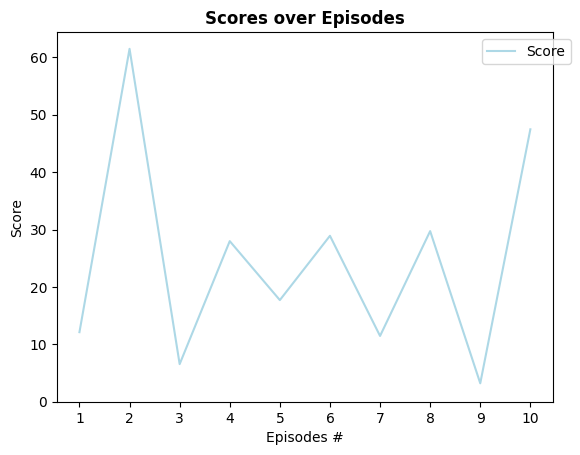

In [86]:
# Plotting the scores and timestep per episode.
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_array)+1), scores_array, label="Score", color='lightblue')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.ylabel('Score')
plt.ylim(0,)
plt.xticks(np.arange(1, len(scores_array)+1))
plt.xlabel('Episodes #')
plt.title("Scores over Episodes", fontweight='bold' )
plt.show()

**Insights:** Analyzing the scores from the DQN model reveals some interesting patterns and highlights areas for improvement. Firstly, the variation in scores across episodes indicates a degree of inconsistency in the model's performance. Despite some impressive scores, such as 61.48 in episode 2, there are instances of lower scores, for instance, 3.21 in episode 9. This discrepancy suggests that the model's current strategy of veering to the right to accrue points often leads to crashes, undermining the overall performance. The model's preference for moving right appears to be an exploitation of the current reward system, indicating a need to adjust this system to discourage risky maneuvers. It's also worth noting that the model's inability to consistently achieve high scores might be due to inefficient reward mechanisms for maintaining safe distance and appropriate lane changes. Thus, to improve the model's performance, changes in these reward structures, as well as a more balanced reward system for different driving maneuvers, could be beneficial.

------------------------------

##  **Part IX: Model Comparison**

Assessing the performance and stability of the tested models - Setting 1 and 2.

**🥇 Average Reward:**

| Setting 1 (PPO, 20000 timesteps, Reward Function 1, Hyperparameter Set 1) | Setting 2 (DQN, 6000 timesteps, Reward Function 2, Hyperparameter Set 2) |
| --- | --- |
| 46.90 points | 26.67 points |

**📈 Standard Deviation (Measure of Reward Stability):**

| Setting 1 (PPO, Reward Function 1, Hyperparameter Set 1) | Setting 2 (DQN, Reward Function 2, Hyperparameter Set 2) |
| --- | --- |
| 0.77 units | 18.56 units |

**Note:** The lower the better, more stable.

**🏋🏼‍♂️ Improvement in regards to 10 Iteration Test with the Same Policy and Agent but no Training:**

| Setting 1 (PPO, Reward Function 1, Hyperparameter Set 1) | Setting 2 (DQN, Reward Function 2, Hyperparameter Set 2) |
| --- | --- |
| 149.78% | -44.33% |

Setting 1 achieved a substantially greater average reward of 46.90 points, compared to Setting 2's 26.67 points. This suggests that the PPO algorithm, together with Reward Function 1 and Hyperparameter Set 1, was more successful in teaching the agent to navigate the Highway environment and acquire rewards.

Furthermore, Setting 1 demonstrated a lower standard deviation of 0.77 units, indicating a more stable reward performance. On the other hand, Setting 2 exhibited a much higher standard deviation of 18.56 units, suggesting that the DQN algorithm, Reward Function 2, and Hyperparameter Set 2 resulted in more inconsistent and volatile agent behavior.

In terms of improvement compared to a 10 iteration test with the same policy and agent but no training, Setting 1 showed a remarkable increase of 149.78% in average reward, showcasing the effectiveness of the PPO algorithm, Reward Function 1, and Hyperparameter Set 1 in training the agent to achieve the project's objective. Setting 2, on the other hand, saw a -44.33% decrease in average reward, showing that the DQN algorithm, Reward Function 2, and Hyperparameter Set 2 were less successful in enhancing the agent's performance when compared to its original state.

Overall, although both settings failed to reach the average reward goal of 50 points, based on these results, it can be concluded that Setting 1 (PPO, Reward Function 1, Hyperparameter Set 1) outperformed Setting 2 (DQN, Reward Function 2, Hyperparameter Set 2) in terms of average reward, reward stability, and improvement compared to its initial agent's performance. The PPO algorithm proved to be more effective in training the agent to drive the ambulance faster and safer in the Highway environment, providing valuable insights for the development of autonomous driving algorithms in a real-world scenario.

------------------------------

##  **Part X: Limitations and Improvement Opportunities**

Reflecting on the main project limitations and future improvement opportunities.

**⛓🔭 Limitations & Improvement Opportunities:**

- **💻 Lack of Computer Power to Perform more Timesteps:** The computational resources available on local machines were limited, which constrained the number of training timesteps that could be performed. As a result, the agent's training might not have reached the optimal number of iterations necessary for achieving higher levels of performance and convergence. 

To overcome this limitation in future iterations, leveraging ☁ cloud solutions or exploring ways to ◼▪ reduce the input dimensionality could be considered. By utilizing more powerful computing resources or reducing the computational complexity of the simulation input, the training process could be extended to allow for a more comprehensive exploration of the environment, potentially leading to improved results.

- **🚑 Too Passive Behavior given the Urgency:** Despite efforts to adjust the reward function to balance safety and speed and modifying the gamma parameter to promote riskier and more short-term point-focused behaviors, the trained agent exhibited a relatively passive driving style, which resulted in slower driving speeds than desired. This limitation implies that the agent may have prioritized safety over urgency, potentially hindering its ability to respond swiftly in emergency situations. 

To address this limitation in future iterations, additional adjustments could be made to the reward function and hyperparameters. Specifically, fine-tuning the reward weights, especially in terms of right lane and high-speed rewards, could encourage more aggressive and urgent driving behaviors. Furthermore, introducing a new reward component that incentivizes the number of cars rendered behind the ambulance could potentially enhance the agent's sense of urgency and responsiveness in navigating the environment.

------------------------------